In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import gc
import warnings
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

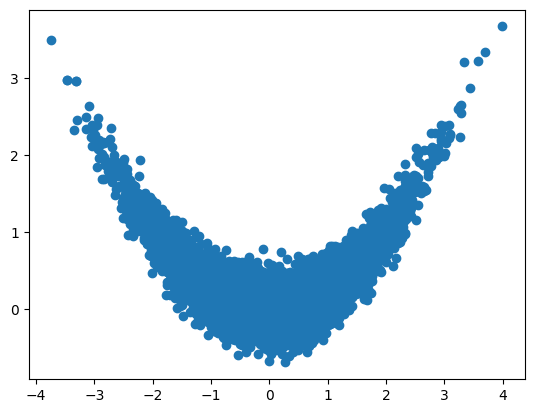

In [17]:
def sample_banana(n_samples=5000, sigma=1.0, noise=0.2):
    u = np.random.normal(0, sigma, size=n_samples)
    x1 = u
    x2 = (u**2)/4 + np.random.normal(0, noise, size=n_samples)
    return np.stack([x1, x2], axis=1)

# Sample data
X = sample_banana(10000)
plt.scatter(X[:,0], X[:,1])

In [5]:
class ICNN(nn.Module):
    def __init__(self, n_dim, hidden_dims):
        super(ICNN, self).__init__()
        self.n_dim = n_dim
        self.hidden_dims = hidden_dims
        self.alpha = 1.0  

        self.Wx_layers = nn.ModuleList()
        self.Wz_layers = nn.ModuleList()
        self.b = nn.ParameterList()


        prev_dim = 0
        for idx, hidden_dim in enumerate(hidden_dims):
            wx = nn.Linear(n_dim, hidden_dim)
            wz = nn.Linear(prev_dim, hidden_dim)

            if idx==0:
                with torch.no_grad():
                    wz.weight.zero_()

            self.Wx_layers.append(wx)
            self.Wz_layers.append(wz)
            self.b.append(nn.Parameter(torch.zeros(hidden_dim)))

            prev_dim = hidden_dim
        self.output_layer = nn.Linear(hidden_dims[-1], 1, bias=False)

    def forward(self, x):
        z = None

        for i in range(len(self.hidden_dims)):
            wx_x = self.Wx_layers[i](x)
            if i==0:
                linear_sum = wx_x + self.b[i]
            else:
                wz_z = self.Wz_layers[i](z)
                linear_sum = wx_x + wz_z + self.b[i]
            z = F.softplus(linear_sum)

        output = self.output_layer(z)
        return output

    def enforce_constraints(self):
        """
        Enforces the non-negativity constraint on W^(z) weights and output layer.
        This should be called after the optimizer.step() during training.
        """
        with torch.no_grad():
            for i in range(1, len(self.Wz_layers)):
                self.Wz_layers[i].weight.copy_(torch.abs(self.Wz_layers[i].weight))
            
            # Ensure output layer weights are also non-negative
            self.output_layer.weight.copy_(torch.abs(self.output_layer.weight))



In [22]:
base = torch.distributions.MultivariateNormal(torch.zeros(2, device=device), torch.eye(2, device=device))
def T(xy):
    x = xy[:,0]
    y = xy[:,1]
    return np.stack([np.cbrt(1/4 * x), np.cbrt(1/4 * y)], axis=1)

X = T(base.sample_n(10000).cpu().numpy())


In [18]:
class DeepConvexFlow(torch.nn.Module):
    """
    Deep convex potential flow parameterized by an input-convex neural network
    """

    def __init__(self, icnn, dim, n_icnns=3, unbiased=False, no_bruteforce=True, m1=10, m2=None, rtol=0.0, atol=1e-3,
                 bias_w1=0.0, trainable_w0=True):
        super(DeepConvexFlow, self).__init__()
        if m2 is None:
            m2 = dim
        
        # Create multiple ICNNs if n_icnns > 1, otherwise keep single ICNN
        if n_icnns > 1:
            self.icnn = nn.ModuleList([icnn for _ in range(n_icnns)])
            # Create separate beta parameters for each ICNN
            self.beta = nn.Parameter(torch.zeros(n_icnns) + bias_w1)
        else:
            self.icnn = icnn
            self.beta = nn.Parameter(torch.zeros(1) + bias_w1)
        
        self.n_icnns = n_icnns
        self.no_bruteforce = no_bruteforce
        self.rtol = rtol
        self.atol = atol

        self.w0 = torch.nn.Parameter(torch.log(torch.exp(torch.ones(1)) - 1), requires_grad=trainable_w0)
        # Keep w1 for backward compatibility or remove if not needed
        self.w1 = torch.nn.Parameter(torch.zeros(1) + bias_w1)
        self.bias_w1 = bias_w1

        self.m1, self.m2 = m1, m2
        
    def get_potential(self, x, context=None):
        n = x.size(0)
        
        if self.n_icnns > 1:
            # Weighted sum of multiple ICNNs with individual beta weights
            icnn_weighted_sum = 0
            for i, icnn in enumerate(self.icnn):
                if context is None:
                    icnn_output = icnn(x)
                else:
                    icnn_output = icnn(x, context)
                icnn_weighted_sum += F.softplus(self.beta[i]) * icnn_output
        else:
            # Single ICNN case
            if context is None:
                icnn_output = self.icnn(x)
            else:
                icnn_output = self.icnn(x, context)
            icnn_weighted_sum = F.softplus(self.beta[0]) * icnn_output
        
        return icnn_weighted_sum + F.softplus(self.w0) * (x.view(n, -1) ** 2).sum(1, keepdim=True) / 2
    
    
    def reverse(self, y, max_iter=1000000, lr=1.0, tol=1e-12, x=None, context=None, **kwargs):
        if x is None:
            x = y.clone().detach().requires_grad_(True)

        def closure():
            # Solves x such that f(x) - y = 0
            # <=> Solves x such that argmin_x F(x) - <x,y>
            F = self.get_potential(x, context)
            loss = torch.sum(F) - torch.sum(x * y)
            x.grad = torch.autograd.grad(loss, x)[0].detach()
            return loss

        optimizer = torch.optim.LBFGS([x], lr=lr, line_search_fn="strong_wolfe", max_iter=max_iter, tolerance_grad=tol,
                                      tolerance_change=tol)

        optimizer.step(closure)

        error_new = (self.forward_transform(x, context=context)[0] - y).abs().max().item()
        # if error_new > math.sqrt(tol):
        #     print('inversion error', error_new, flush=True)
        torch.cuda.empty_cache()
        gc.collect()

        return x

    def forward(self, x, context=None):
        with torch.enable_grad():
            x = x.clone().requires_grad_(True)
            F = self.get_potential(x, context)
            f = torch.autograd.grad(F.sum(), x, create_graph=True)[0]
        return f

    def forward_transform(self, x, logdet=0, context=None, extra=None):

        return self.forward_transform_bruteforce(x, logdet, context=context)

    def forward_transform_bruteforce(self, x, logdet=0, context=None):
        warnings.warn('brute force')
        bsz = x.shape[0]
        input_shape = x.shape[1:]

        with torch.enable_grad():
            x.requires_grad_(True)
            F = self.get_potential(x, context)
            f = torch.autograd.grad(F.sum(), x, create_graph=True)[0]

            # TODO: compute Hessian in block mode instead of row-by-row.
            f = f.reshape(bsz, -1)
            H = []
            for i in range(f.shape[1]):
                retain_graph = self.training or (i < (f.shape[1] - 1))
                H.append(
                    torch.autograd.grad(f[:, i].sum(), x, create_graph=self.training, retain_graph=retain_graph)[0])

            # H is (bsz, dim, dim)
            H = torch.stack(H, dim=1)

        f = f.reshape(bsz, *input_shape)
        return f, logdet + torch.slogdet(H).logabsdet

    def extra_repr(self):
        return f"ConjGrad(rtol={self.rtol}, atol={self.atol})"


In [23]:
icnn = ICNN(n_dim=2, hidden_dims=[16, 32, 16]).to(device)
model = DeepConvexFlow(icnn, 2, n_icnns=3).to(device)


def train(X, model, epochs=200, lr=5e-2, dim=2):
    EPOCHS = epochs
    LR=lr
    base = torch.distributions.MultivariateNormal(torch.zeros(dim, device=device), torch.eye(dim, device=device))
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

    X_tensor = torch.tensor(X, dtype=torch.float32, device=device)

    dataset = TensorDataset(X_tensor)
    dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

    for epoch in range(1, EPOCHS + 1):
        total_loss = 0.0
        for (x_batch,) in dataloader:
            x_batch = x_batch.to(device)


            y, logdet = model.forward_transform(x_batch, logdet=0.0)
            logp0 = base.log_prob(y)
            logpx = logp0 + logdet

            loss = -logpx.mean()  # NLL = reverse KL

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if hasattr(model.icnn, '__iter__'):  # Multiple ICNNs case
                for icnn in model.icnn:
                    icnn.enforce_constraints()
            else:  # Single ICNN case
                model.icnn.enforce_constraints()



            total_loss += loss.item() * x_batch.size(0)
        
        scheduler.step()

        
        
        if epoch % 5 == 0:
            print(f"Epoch {epoch}/{EPOCHS}, NLL = {total_loss/len(X):.4f}")

train(X, model, epochs=200, lr=5e-2)

/home/mohamed/miniconda3/lib/python3.12/site-packages/torch/nn/init.py:452: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/tmp/ipykernel_1379/197411439.py:93: UserWarning: brute force
  warnings.warn('brute force')


Epoch 5/200, NLL = 1.6893
Epoch 10/200, NLL = 1.6186
Epoch 15/200, NLL = 1.3599
Epoch 20/200, NLL = 0.6504
Epoch 25/200, NLL = 0.6400
Epoch 30/200, NLL = 0.6201
Epoch 35/200, NLL = 0.6140
Epoch 40/200, NLL = 0.6031
Epoch 45/200, NLL = 0.6194
Epoch 50/200, NLL = 0.6129
Epoch 55/200, NLL = 0.5978
Epoch 60/200, NLL = 0.5996
Epoch 65/200, NLL = 0.5947
Epoch 70/200, NLL = 0.5985
Epoch 75/200, NLL = 0.5941
Epoch 80/200, NLL = 0.6032
Epoch 85/200, NLL = 0.5959
Epoch 90/200, NLL = 0.5963
Epoch 95/200, NLL = 0.5993
Epoch 100/200, NLL = 0.5949
Epoch 105/200, NLL = 0.5913
Epoch 110/200, NLL = 0.5909
Epoch 115/200, NLL = 0.5911
Epoch 120/200, NLL = 0.5899
Epoch 125/200, NLL = 0.5911
Epoch 130/200, NLL = 0.5902
Epoch 135/200, NLL = 0.5916
Epoch 140/200, NLL = 0.5916
Epoch 145/200, NLL = 0.5916
Epoch 150/200, NLL = 0.5887
Epoch 155/200, NLL = 0.5881
Epoch 160/200, NLL = 0.5894
Epoch 165/200, NLL = 0.5882
Epoch 170/200, NLL = 0.5906
Epoch 175/200, NLL = 0.5872
Epoch 180/200, NLL = 0.5875
Epoch 185/20

/home/mohamed/miniconda3/lib/python3.12/site-packages/torch/distributions/distribution.py:179: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn(
/tmp/ipykernel_1379/197411439.py:93: UserWarning: brute force
  warnings.warn('brute force')


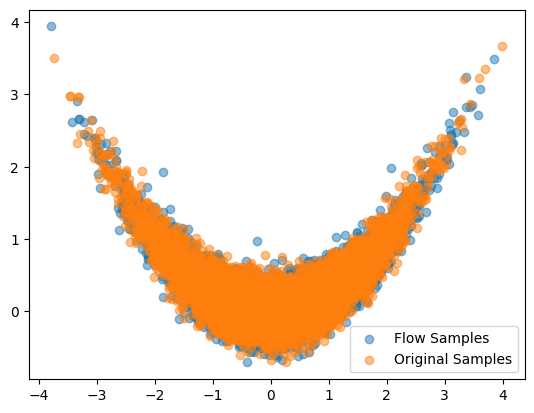

In [21]:
base = torch.distributions.MultivariateNormal(torch.zeros(2, device=device), torch.eye(2, device=device))
flow_samples = model.reverse(base.sample_n(10000).to(device), max_iter=1000, lr=1.0, tol=1e-8)
flow_samples = flow_samples.cpu().detach().numpy()
plt.scatter(flow_samples[:,0], flow_samples[:,1], alpha=0.5, label='Flow Samples')
plt.scatter(X[:,0], X[:,1], alpha=0.5, label='Original Samples')
plt.legend()


/tmp/ipykernel_1379/197411439.py:93: UserWarning: brute force
  warnings.warn('brute force')


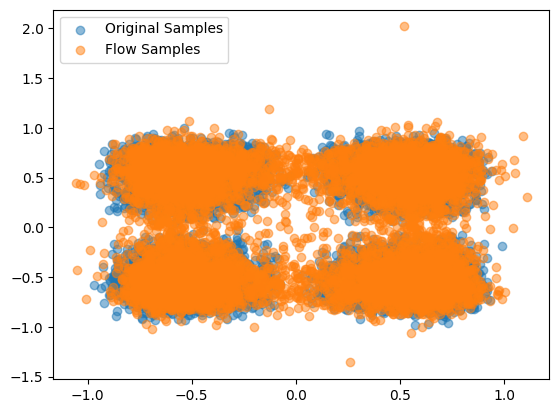

In [25]:
flow_samples = model.reverse(base.sample_n(10000).to(device), max_iter=1000, lr=1.0, tol=1e-8)
flow_samples = flow_samples.cpu().detach().numpy()
plt.scatter(X[:,0], X[:,1], alpha=0.5, label='Original Samples')
plt.scatter(flow_samples[:,0], flow_samples[:,1], alpha=0.5, label='Flow Samples')

plt.legend()
